In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
import io
# from keras_vggface.vggface import VGGFace
from skimage.transform import resize

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/fer2013.csv")


In [ ]:
def convert_pixels_to_img(pixels):
    pixels = pixels/255
    test_image = pixels.reshape(48,48)
    test_image = resize(test_image, (75, 75))


    return test_image

def split_pixels(string):
    splitted = np.array(string.split(),'int')
    return splitted 

def change_to_categorical(sample):
    return keras.utils.to_categorical(sample,num_classes=7)

def grayscale_to_rgb(grayscale_image): 
    rgb_image = np.stack((grayscale_image,)*3, axis=-1)
    return rgb_image 

dataset['pixels'] = dataset['pixels'].apply(split_pixels)
dataset['label'] = dataset['emotion'].apply(change_to_categorical)
dataset['length'] = dataset['pixels'].apply(len)

dataset = dataset[dataset.length == 2304]
dataset['image'] = dataset['pixels'].apply(convert_pixels_to_img)
dataset['image'] = dataset['image'].apply(grayscale_to_rgb)

In [ ]:
grouped_dataset = dataset.groupby(dataset.Usage)
training_dataset = grouped_dataset.get_group("Training")
dev_dataset = grouped_dataset.get_group("PublicTest")
test_dataset = grouped_dataset.get_group("PrivateTest")

In [ ]:
training_dataset = training_dataset.loc[training_dataset["emotion"]!=1]
dev_dataset = dev_dataset.loc[dev_dataset["emotion"]!=1]
test_dataset = test_dataset.loc[test_dataset["emotion"]!=1]
def balancingDataset(x):
  new_df=training_dataset.loc[dataset['emotion']==x]
  new_df=new_df[:3000]
  return new_df
df_0=balancingDataset(0)
df_2=balancingDataset(2)
df_3=balancingDataset(3)
df_4=balancingDataset(4)
df_5=balancingDataset(5)
df_6=balancingDataset(6)


training_dataset=pd.concat([df_0,df_2,df_3,df_4,df_5,df_6])
training_dataset

,emotion,pixels,Usage,label,length,image
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2304,"[[[0.2762603921568623, 0.2762603921568623, 0.2..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2304,"[[[0.5913239215686275, 0.5913239215686275, 0.5..."
10,0,"[30, 24, 21, 23, 25, 25, 49, 67, 84, 103, 120,...",Training,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2304,"[[[0.11373647058823551, 0.11373647058823551, 0..."
22,0,"[123, 125, 124, 142, 209, 226, 234, 236, 231, ...",Training,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2304,"[[[0.4837647058823529, 0.4837647058823529, 0.4..."
23,0,"[8, 9, 14, 21, 26, 32, 37, 46, 52, 62, 72, 70,...",Training,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2304,"[[[0.03329254901960784, 0.03329254901960784, 0..."
...,...,...,...,...,...,...
17073,6,"[101, 105, 136, 141, 165, 167, 164, 170, 170, ...",Training,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2304,"[[[0.3766243137254892, 0.3766243137254892, 0.3..."
17075,6,"[116, 131, 120, 84, 43, 55, 58, 61, 61, 66, 70...",Training,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2304,"[[[0.4642196078431368, 0.4642196078431368, 0.4..."
17081,6,"[255, 255, 254, 254, 254, 254, 254, 255, 255, ...",Training,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2304,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.9996078..."
17082,6,"[50, 52, 50, 49, 44, 51, 51, 41, 33, 39, 43, 4...",Training,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2304,"[[[0.20025725490196086, 0.20025725490196086, 0..."


In [ ]:
# Pandas dataframe
x_train = training_dataset['image']
y_train = training_dataset['label']
x_test =  dev_dataset['image']
y_test = dev_dataset['label']

#Pandas dataframe to numpy
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

#numpy array reshape to fit into model
x_train = np.stack(x_train,axis=0)
y_train = np.stack(y_train,axis=0)
x_test = np.stack(x_test,axis=0)
y_test = np.stack(y_test,axis=0)

In [ ]:

emotion_labels = {0:'Angry', 1:'Disgust',2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
def int_to_emotion(x):
    return emotion_labels[x]
def get_distribution(data):
    emotion_count = data['emotion'].value_counts()
    
    #emotion_count.index = emotion_count.index.map(int_to_emotion)
    print("Distribution count of emotions in the dataset:")
    print(emotion_count)

In [ ]:
datagen = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
generator=datagen.flow(x_train,y_train,batch_size=64)

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

inception = InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(75,75,3))

x = inception.output
x = layers.Flatten()(x)
x = layers.Dense(units=4096,activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(units=2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(units=7, activation="softmax")(x)

new_model = keras.Model(inputs=inception.input, outputs=x)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, mode='auto')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Emotion Recognition/Model/inception_undersampling.h5', monitor='val_loss', verbose=1, save_best_only=True)


new_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
new_model.summary()

history = new_model.fit(generator,batch_size=64,epochs=100,verbose=1,validation_data=(x_test, y_test),callbacks=[lr_reducer,early_stopper,checkpointer])

219062272/219055592 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
___________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


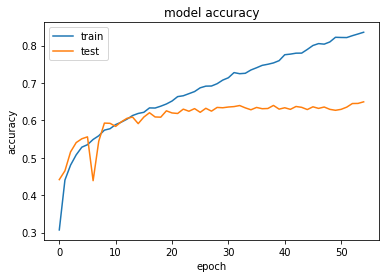

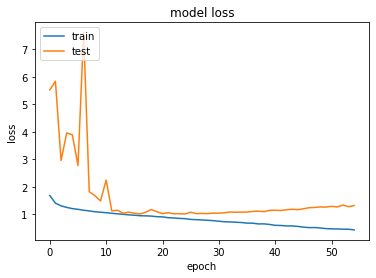

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
x_test =  test_dataset['image']
y_test = test_dataset['label']

#Pandas dataframe to numpy
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

#numpy array reshape to fit into model
x_test = np.stack(x_test,axis=0)
y_test = np.stack(y_test,axis=0)

In [ ]:
new_model.evaluate(x_test,y_test)


111/111 [==============================] - 5s 43ms/step - loss: 1.1968 - accuracy: 0.6545


[1.1968165636062622, 0.6544991731643677]